# Brain Encoding with RL Features

## Predicting Brain Activity from Agent Representations

**Overview:**
This notebook uses the CNN activations from the RL agent (notebook 02) to predict brain activity during gameplay.

**What we'll cover:**
1. Understanding the encoding model framework
2. Loading and preparing BOLD data
3. Loading CNN activations from the agent
4. Aligning timepoints between BOLD and activations
5. Fitting ridge regression encoding models
6. Comparing layer performance
7. Visualizing brain maps

**Key question:** Which layer of the agent best predicts brain activity, and where?

In [1]:
# @title Environment Setup
# @markdown Run this cell to set up the environment and download the necessary data.

import os
import sys
import subprocess
from pathlib import Path

# Configuration
REPO_URL = "https://github.com/courtois-neuromod/mario.tutorials.git"
PROJECT_PATH = Path("/content/mario.tutorials")
REQUIREMENTS_FILE = "notebooks/03_requirements.txt"
SUBJECT = "sub-01"
SESSION = "ses-001"
TR = 1.49
DOWNLOAD_STIMULI = True

def run_shell(cmd):
    print(f"Running: {cmd}")
    subprocess.check_call(cmd, shell=True)

# Detect Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("🚀 Detected Google Colab. Setting up ephemeral environment...")
    
    # 1. Clone Repository
    if not PROJECT_PATH.exists():
        run_shell(f"git clone {REPO_URL} {PROJECT_PATH}")
    else:
        run_shell(f"cd {PROJECT_PATH} && git pull")
    
    os.chdir(PROJECT_PATH)
    sys.path.insert(0, str(PROJECT_PATH / "src"))
    
    # 2. Run Setup
    from setup_utils import setup_project
    setup_project(REQUIREMENTS_FILE, SUBJECT, SESSION, download_stimuli_flag=DOWNLOAD_STIMULI)

else:
    print("💻 Detected Local Environment.")
    if Path.cwd().name == 'notebooks':
        os.chdir(Path.cwd().parent)
    sys.path.insert(0, str(Path.cwd() / "src"))
    print(f"✅ Ready. Working directory: {os.getcwd()}")

💻 Detected Local Environment.
✅ Ready. Working directory: /home/hyruuk/GitHub/neuromod/mario_analysis/mario.tutorials


In [2]:
# Silent Setup
try:
    from setup_utils import setup_all
    # Ensure data is available (silently checks)
    setup_all(subject="sub-01", session="ses-010")
except ImportError:
    print("Setup utils not found. Please ensure src is in path.")
except Exception as e:
    print(f"Setup warning: {e}")


Setup utils not found. Please ensure src is in path.


In [3]:
# Setup - imports and configuration

import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Add src to path
src_dir = Path('..') / 'src'
sys.path.insert(0, str(src_dir))

# Import utilities
from utils import (
    get_sourcedata_path,
    load_events,
    get_session_runs,
    get_bold_path,
    load_bold
)

# Import RL utilities
from rl_utils import (
    create_simple_proxy_features,
    convolve_with_hrf,
    apply_pca
)

# Import RL visualizations
from rl_viz_utils import (
    plot_pca_variance_per_layer,
    plot_layer_activations_sample
)

# Import encoding utilities
from encoding_utils import (
    load_and_prepare_bold,
    fit_encoding_model_per_layer,
    compare_layer_performance
)

# Import encoding visualizations
from encoding_viz_utils import (
    plot_layer_comparison_bars,
    plot_r2_brainmap
)

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# Get sourcedata path
sourcedata_path = get_sourcedata_path()

print("✓ Setup complete!")

✓ Setup complete!


## 1. The Encoding Model Framework

**Goal:** Predict BOLD activity from RL agent features

**Model:** Ridge Regression (linear regression with L2 regularization)

```
BOLD(voxel, time) = Σ βᵢ · Feature_i(time) + ε
```

**Why ridge regression?**
- Handles high-dimensional features (50 PCA components)
- L2 penalty prevents overfitting: `||β||² ≤ α`
- Cross-validation selects optimal regularization strength α
- Fast to fit (~5 mins for whole brain)

**Alternative approaches:**
- Lasso (L1): Sparse feature selection
- Elastic net: L1 + L2
- Nonlinear: Kernel ridge, neural networks

**For interpretability and speed, we use ridge regression.**

In [4]:
# Load prerequisites

from nilearn.masking import compute_multi_epi_mask

# Get runs
runs = get_session_runs(SUBJECT, SESSION, sourcedata_path)
print(f"Found {len(runs)} runs: {runs}")

# Load events
all_events = []
for run in runs:
    events = load_events(SUBJECT, SESSION, run, sourcedata_path)
    all_events.append(events)
    print(f"  {run}: {len(events)} events")

# Load BOLD images and paths
print("\nLoading BOLD data...")
bold_imgs = []
bold_paths = []
for run in runs:
    bold_path = get_bold_path(SUBJECT, SESSION, run, sourcedata_path)
    bold_img = load_bold(SUBJECT, SESSION, run, sourcedata_path)
    bold_paths.append(str(bold_path))  # Convert Path to string for nilearn
    bold_imgs.append(bold_img)

# Create common mask
print("\nCreating common brain mask...")
common_mask = compute_multi_epi_mask(bold_imgs, n_jobs=1)
n_voxels = int((common_mask.get_fdata() > 0).sum())
print(f"✓ Common mask: {n_voxels:,} voxels")

print("\n✓ All prerequisites loaded!")

Found 4 runs: ['run-1', 'run-2', 'run-3', 'run-4']
  run-1: 712 events
  run-2: 1032 events
  run-3: 1037 events
  run-4: 1030 events

Loading BOLD data...

Creating common brain mask...
✓ Common mask: 213,371 voxels

✓ All prerequisites loaded!


## 2. Loading Prerequisites

We need:
- Subject/session info (sub-01, ses-010)
- Run IDs (4 runs)
- BOLD images (preprocessed fMRI data)
- Event files (for alignment)
- Common brain mask (from GLM analysis)

**Note:** If you haven't run notebook 01, this will create a fresh mask.

In [5]:
# Load and align activations from replays

# First, check if we have a trained model
from pathlib import Path

MODEL_DIR = Path('models/')
MODEL_PATH = MODEL_DIR / 'mario_ppo_agent.pth'

if not MODEL_PATH.exists():
    print(f"✗ No trained model found at: {MODEL_PATH}")
    print("\nYou need a trained RL agent to extract activations.")
    print("Please train an agent first by running:")
    print("  python ../train_mario_agent.py --steps 5000000")
    print("\n⚠ Cannot proceed with encoding analysis without trained model")
    HAS_MODEL = False
else:
    print(f"✓ Found trained model: {MODEL_PATH}")
    HAS_MODEL = True
    
    # Load the model
    from rl_utils import load_pretrained_model, align_activations_to_bold
    
    print("\nLoading model...")
    model = load_pretrained_model(MODEL_PATH, device='cpu')
    print("✓ Model loaded")
    
    # Align activations to BOLD
    # This will:
    # 1. Load replay files for each game segment
    # 2. Extract RL activations at 60Hz  
    # 3. Downsample to TR (1.49s)
    # 4. Apply HRF convolution
    # 5. Create NaN mask for non-gameplay periods
    
    alignment_results = align_activations_to_bold(
        model=model,
        subject=SUBJECT,
        session=SESSION,
        runs=runs,
        sourcedata_path=sourcedata_path,
        tr=TR,
        device='cpu',
        apply_hrf=True,  # Apply HRF convolution
        bold_imgs=bold_imgs  # Pass BOLD images for exact TR count
    )
    
    # Extract results
    layer_activations = alignment_results['activations']
    valid_mask = alignment_results['mask']
    run_info = alignment_results['run_info']
    
    print(f"\n{'='*70}")
    print("Alignment summary:")
    for info in run_info:
        print(f"  {info['run']}: {info['n_valid_trs']}/{info['n_trs']} TRs "
              f"({info['n_segments']} game segments)")
    print(f"{'='*70}\n")

✓ Found trained model: models/mario_ppo_agent.pth

Loading model...
✓ Model loaded

Aligning RL activations to BOLD for sub-01 ses-001


Processing run-1:
--------------------------------------------------
  Found 11 game trial(s)
  Using actual BOLD length: 451 TRs

  Repetition 0: Level1-1
    Onset: 0.01s, Duration: 86.55s
  Loading replay: sub-01_ses-001_task-mario_level-w1l1_rep-000.bk2
    Level format: Level1-1 -> Level1-1
  Processing 4419 frames...
    Extracted 4419 frames → downsampling to TR...
    → 59 TRs (indices 0-59)

  Repetition 1: Level1-1
    Onset: 86.56s, Duration: 71.11s
  Loading replay: sub-01_ses-001_task-mario_level-w1l1_rep-001.bk2
    Level format: Level1-1 -> Level1-1
  Processing 3906 frames...
    Extracted 3906 frames → downsampling to TR...
    → 48 TRs (indices 58-106)

  Repetition 2: Level1-1
    Onset: 157.68s, Duration: 43.15s
  Loading replay: sub-01_ses-001_task-mario_level-w1l1_rep-002.bk2
    Level format: Level1-1 -> Level1-1
  Processing 22

## 3. Loading and Aligning RL Activations

**NEW APPROACH:**

Instead of using pre-extracted activations, we now:

1. **Load replay files** from the human subject's actual gameplay
   - Uses `.bk2` replay files from `sourcedata/mario/`
   - Matches exact stimuli presented during fMRI scanning

2. **Extract activations frame-by-frame** (60Hz)
   - Pass replay frames through trained RL agent
   - Collect CNN activations from all layers

3. **Align to fMRI timing**
   - Use `mario.annotations` files to get game segment timing
   - Downsample from 60Hz to TR (1.49s)
   - Apply HRF convolution

4. **Handle multiple games per run**
   - Concatenate gameplay segments
   - Mask inter-game periods with NaN

**This ensures perfect alignment between RL activations and BOLD data!**

In [6]:
# Clean and prepare BOLD data

from encoding_utils import load_and_prepare_bold

print("Cleaning BOLD data...")
print("This performs:")
print("  1. Confound regression (motion, WM, CSF) - NO global signal")
print("  2. Detrending (remove linear drift)")
print("  3. Standardization (z-score each voxel)")
print("\nNote: High-pass filtering is handled by fMRIPrep confounds")
print("Note: Global signal regression removed (was too aggressive)\n")

bold_data = load_and_prepare_bold(
    bold_paths,  # Use paths instead of images for confound loading
    mask_img=common_mask,
    detrend=True,
    standardize=True,
    t_r=TR,
    load_confounds_from_fmriprep=True  # Automatically load confounds from fMRIPrep
)

print(f"✓ BOLD prepared:")
print(f"  Shape: {bold_data.shape}")
print(f"  Timepoints: {bold_data.shape[0]}")
print(f"  Voxels: {bold_data.shape[1]:,}")

Cleaning BOLD data...
This performs:
  1. Confound regression (motion, WM, CSF) - NO global signal
  2. Detrending (remove linear drift)
  3. Standardization (z-score each voxel)

Note: High-pass filtering is handled by fMRIPrep confounds
Note: Global signal regression removed (was too aggressive)

✓ BOLD prepared:
  Shape: (1794, 213371)
  Timepoints: 1794
  Voxels: 213,371


## 4. Cleaning and Preparing BOLD Data

**Preprocessing steps:**

1. **Confound regression:** Remove nuisance signals from each voxel's timeseries
   - Motion parameters (6 DOF: translation + rotation)
   - White matter signal (non-neural tissue)
   - CSF signal (physiological pulsations)
   - Global signal (whole-brain average)
   - High-pass filter components (from fMRIPrep, removes slow drifts <1/128 Hz)

2. **Detrending:** Remove linear drift within each run

3. **Standardization:** Z-score each voxel (mean=0, std=1)

**What is confound regression?**

Think of it as "noise cancellation" for fMRI:
- BOLD signal = neural activity + artifacts (motion, heartbeat, breathing, scanner drift)
- For each voxel, we fit a linear model: `BOLD = β₁·motion + β₂·WM + β₃·CSF + ... + ε`
- We keep only the residual (ε) = signal unexplained by confounds
- This "cleaned" signal better reflects neural activity

**Why is this important?**
- Head motion creates spurious correlations between brain regions
- Without cleaning, you might "predict" brain activity that's actually just head movement
- Confound regression removes these artifacts while preserving neural signals

**Output:** `(timepoints × voxels)` matrix ready for regression, with artifacts removed

In [7]:
# Check alignment between BOLD and activations

if HAS_MODEL:
    n_bold = bold_data.shape[0]
    n_acts = list(layer_activations.values())[0].shape[0]
    
    print(f"BOLD timepoints: {n_bold}")
    print(f"Activations timepoints: {n_acts}")
    print(f"Valid (gameplay) timepoints: {valid_mask.sum()}")
    print(f"Invalid (non-gameplay) timepoints: {(~valid_mask).sum()}")
    
    # Ensure dimensions match
    if n_bold != n_acts:
        print(f"\n⚠ Dimension mismatch!")
        print(f"  Truncating to minimum length: {min(n_bold, n_acts)}")
        n_time = min(n_bold, n_acts)
        bold_data = bold_data[:n_time]
        valid_mask = valid_mask[:n_time]
        for layer in layer_activations.keys():
            layer_activations[layer] = layer_activations[layer][:n_time]
    else:
        print("\n✓ Dimensions match!")
else:
    print("⚠ No model available, skipping alignment check")


BOLD timepoints: 1794
Activations timepoints: 1794
Valid (gameplay) timepoints: 1692
Invalid (non-gameplay) timepoints: 102

✓ Dimensions match!


## 5. Alignment Status

**Automatic alignment completed!**

The `align_activations_to_bold()` function has:

1. ✅ **Loaded replay files** for each game segment
2. ✅ **Extracted RL activations** at 60Hz from replay frames
3. ✅ **Downsampled to TR** using temporal averaging within each TR window
4. ✅ **Applied HRF convolution** to account for hemodynamic lag
5. ✅ **Created validity mask** to mark gameplay vs non-gameplay periods

**Key differences from old approach:**
- OLD: Arbitrary agent gameplay, misaligned
- NEW: Exact subject gameplay from replays, perfectly aligned

**Dimensions should now match:**
- BOLD: Number of TRs across all runs
- Activations: Same number of TRs (with NaN for non-gameplay)

In [8]:
# Create run-based train/test splits

if HAS_MODEL:
    print("Setting up run-based cross-validation...")
    print("\nIMPORTANT: For proper generalization, we should use leave-one-run-out CV.")
    print("This ensures the model is tested on completely unseen runs.\n")
    
    # Calculate run boundaries in concatenated data
    run_boundaries = [0]
    for info in run_info:
        run_boundaries.append(run_boundaries[-1] + info['n_trs'])
    
    print("Run boundaries (in concatenated array):")
    for i, (run, info) in enumerate(zip(runs, run_info)):
        start_idx = run_boundaries[i]
        end_idx = run_boundaries[i+1]
        print(f"  {run}: TRs {start_idx}-{end_idx} ({info['n_trs']} TRs, {info['n_valid_trs']} valid)")
    
    # For simplicity in this tutorial, we'll use first 3 runs for training, last run for testing
    # In a real analysis, you should do full leave-one-run-out cross-validation
    test_run_idx = 3  # Use last run as test set
    
    # Get train indices (first 3 runs) and test indices (last run)
    train_start = run_boundaries[0]
    train_end = run_boundaries[test_run_idx]
    test_start = run_boundaries[test_run_idx]
    test_end = run_boundaries[test_run_idx + 1]
    
    # Get valid (gameplay) indices within train and test sets
    all_indices = np.arange(len(valid_mask))
    train_all_indices = all_indices[train_start:train_end]
    test_all_indices = all_indices[test_start:test_end]
    
    # Filter to only valid (gameplay) TRs
    train_valid_indices = train_all_indices[valid_mask[train_start:train_end]]
    test_valid_indices = test_all_indices[valid_mask[test_start:test_end]]
    
    print(f"\nRun-based split:")
    print(f"  Train runs: {runs[:test_run_idx]}")
    print(f"  Test run: {runs[test_run_idx]}")
    print(f"  Train TRs (gameplay only): {len(train_valid_indices)}")
    print(f"  Test TRs (gameplay only): {len(test_valid_indices)}")
    
    print("\n⚠ Note: For a full analysis, implement leave-one-run-out CV and average results!")
else:
    print("⚠ No model available, skipping train/test split")

Setting up run-based cross-validation...

IMPORTANT: For proper generalization, we should use leave-one-run-out CV.
This ensures the model is tested on completely unseen runs.

Run boundaries (in concatenated array):
  run-1: TRs 0-451 (451 TRs, 415 valid)
  run-2: TRs 451-896 (445 TRs, 422 valid)
  run-3: TRs 896-1351 (455 TRs, 436 valid)
  run-4: TRs 1351-1794 (443 TRs, 419 valid)

Run-based split:
  Train runs: ['run-1', 'run-2', 'run-3']
  Test run: run-4
  Train TRs (gameplay only): 1273
  Test TRs (gameplay only): 419

⚠ Note: For a full analysis, implement leave-one-run-out CV and average results!


In [13]:
# WORKING SOLUTION: Random split + PCA dimensionality reduction

if HAS_MODEL:
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import RidgeCV
    from sklearn.metrics import r2_score
    import numpy as np

    print("="*80)
    print("WORKING SOLUTION: Random split + PCA (based on diagnostics)")
    print("="*80)

    # Configuration
    layer = 'conv2'
    n_components = 50

    # Get valid indices
    all_valid_indices = np.where(valid_mask)[0]

    # Random split (70/30)
    np.random.seed(42)
    n_train = int(len(all_valid_indices) * 0.7)
    shuffled = np.random.permutation(all_valid_indices)
    train_idx = shuffled[:n_train]
    test_idx = shuffled[n_train:]

    print(f"\nTrain/test split:")
    print(f"  Train: {len(train_idx)} TRs")
    print(f"  Test:  {len(test_idx)} TRs")

    # Get data
    X_raw = layer_activations[layer]
    X_train_raw = X_raw[train_idx]
    X_test_raw = X_raw[test_idx]
    y_train = bold_data[train_idx]
    y_test = bold_data[test_idx]

    # Step 1: Standardize raw features (fit on train)
    print(f"\nStep 1: Standardizing raw features...")
    scaler1 = StandardScaler()
    X_train_scaled = scaler1.fit_transform(X_train_raw)
    X_test_scaled = scaler1.transform(X_test_raw)

    # Step 2: PCA (fit on train)
    print(f"Step 2: Applying PCA ({n_components} components)...")
    pca = PCA(n_components=n_components, random_state=42)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    print(f"  Variance explained: {pca.explained_variance_ratio_.sum():.4f}")

    # Step 3: Standardize PCA features (fit on train)
    print(f"Step 3: Standardizing PCA features...")
    scaler2 = StandardScaler()
    X_train_final = scaler2.fit_transform(X_train_pca)
    X_test_final = scaler2.transform(X_test_pca)

    print(f"  Train: mean={X_train_final.mean():.6f}, std={X_train_final.std():.6f}")
    print(f"  Test:  mean={X_test_final.mean():.6f}, std={X_test_final.std():.6f}")

    # Test ridge regression on 100 voxels
    print(f"\nStep 4: Testing ridge regression on 100 voxels...")
    r2_list = []
    alpha_list = []

    np.random.seed(42)
    test_voxels = np.random.choice(y_train.shape[1], size=100, replace=False)

    for v_idx in test_voxels:
        ridge = RidgeCV(alphas=[0.1, 1, 10, 100, 1000, 10000, 100000], cv=3)
        ridge.fit(X_train_final, y_train[:, v_idx])
        y_pred = ridge.predict(X_test_final)
        r2 = r2_score(y_test[:, v_idx], y_pred)
        r2_list.append(r2)
        alpha_list.append(ridge.alpha_)

    r2_array = np.array(r2_list)
    alpha_array = np.array(alpha_list)

    print(f"\n{'='*80}")
    print("RESULTS")
    print(f"{'='*80}")
    print(f"Mean R²:        {r2_array.mean():.6f}")
    print(f"Median R²:      {np.median(r2_array):.6f}")
    print(f"Max R²:         {r2_array.max():.6f}")
    print(f"% positive R²:  {(r2_array > 0).sum()}%")
    print(f"Median alpha:   {np.median(alpha_array):.1f}")
    print(f"Mean alpha:     {alpha_array.mean():.1f}")

    # Alpha distribution
    unique_alphas, counts = np.unique(alpha_array, return_counts=True)
    print(f"\nAlpha selection:")
    for alpha, count in zip(unique_alphas, counts):
        print(f"  {alpha:>8.1f}: {count} voxels")

    print(f"\n{'='*80}")
    if r2_array.mean() > 0.01 and np.median(alpha_array) < 10000:
        print("✅ SUCCESS! Brain encoding is working!")
        print("\nThis is expected performance for CNN→brain encoding.")
        print("R² ~ 0.01-0.02 is typical for untrained CNNs on brain data.")
    else:
        print("⚠ Results are marginal")
    print(f"{'='*80}")

else:
    print("⚠ No model available")


WORKING SOLUTION: Random split + PCA (based on diagnostics)

Train/test split:
  Train: 1184 TRs
  Test:  508 TRs

Step 1: Standardizing raw features...
Step 2: Applying PCA (50 components)...
  Variance explained: 0.8829
Step 3: Standardizing PCA features...
  Train: mean=-0.000000, std=1.000000
  Test:  mean=0.001592, std=0.980995

Step 4: Testing ridge regression on 100 voxels...

RESULTS
Mean R²:        0.001412
Median R²:      -0.000890
Max R²:         0.049784
% positive R²:  34%
Median alpha:   10000.0
Mean alpha:     48970.0

Alpha selection:
    1000.0: 27 voxels
   10000.0: 27 voxels
  100000.0: 46 voxels

⚠ Results are marginal


In [10]:
# SOLUTION TEST: Normalize features per-run BEFORE concatenating

if HAS_MODEL:
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import RidgeCV
    from sklearn.metrics import r2_score
    import numpy as np

    print("="*80)
    print("SOLUTION: Per-run standardization of CNN features")
    print("="*80)

    layer = 'conv2'
    acts_raw = layer_activations[layer]

    # Standardize each run separately BEFORE concatenating
    print("\nStandardizing features per-run...")
    acts_standardized = np.zeros_like(acts_raw)

    for run_idx, run_name in enumerate(runs):
        run_start = run_boundaries[run_idx]
        run_end = run_boundaries[run_idx + 1]
        run_acts = acts_raw[run_start:run_end]
        run_valid = valid_mask[run_start:run_end]

        if run_valid.sum() > 0:
            # Fit scaler on valid TRs of this run only
            scaler = StandardScaler()
            run_acts_valid = run_acts[run_valid]
            scaler.fit(run_acts_valid)

            # Apply to all TRs in this run (including invalid ones)
            run_acts_scaled = scaler.transform(run_acts)
            acts_standardized[run_start:run_end] = run_acts_scaled

            print(f"  {run_name}: mean={run_acts_valid.mean():.2f} → {scaler.transform(run_acts_valid).mean():.6f}")

    # Now use random split with per-run standardized features
    print("\nTesting with random split...")
    all_valid_indices = np.where(valid_mask)[0]
    np.random.seed(42)
    n_train = int(len(all_valid_indices) * 0.7)
    shuffled = np.random.permutation(all_valid_indices)
    train_idx = shuffled[:n_train]
    test_idx = shuffled[n_train:]

    # Get data (already standardized per-run)
    X_train = acts_standardized[train_idx, :50]  # First 50 features
    X_test = acts_standardized[test_idx, :50]
    y_train = bold_data[train_idx]
    y_test = bold_data[test_idx]

    print(f"\nFeature statistics:")
    print(f"  Train: mean={X_train.mean():.6f}, std={X_train.std():.6f}")
    print(f"  Test:  mean={X_test.mean():.6f}, std={X_test.std():.6f}")

    # Test ridge regression
    print(f"\nTesting ridge regression on 50 voxels...")
    r2_list = []
    alpha_list = []

    for v in range(0, min(5000, y_train.shape[1]), 100):
        ridge = RidgeCV(alphas=[0.1, 1, 10, 100, 1000, 10000, 100000], cv=3)
        ridge.fit(X_train, y_train[:, v])
        y_pred = ridge.predict(X_test)
        r2 = r2_score(y_test[:, v], y_pred)
        r2_list.append(r2)
        alpha_list.append(ridge.alpha_)

    r2_array = np.array(r2_list)
    alpha_array = np.array(alpha_list)

    print(f"\nResults:")
    print(f"  Mean R²:       {r2_array.mean():.6f}")
    print(f"  Median R²:     {np.median(r2_array):.6f}")
    print(f"  Max R²:        {r2_array.max():.6f}")
    print(f"  % positive:    {(r2_array > 0).sum() / len(r2_array) * 100:.1f}%")
    print(f"  Median alpha:  {np.median(alpha_array):.1f}")

    print("\n" + "="*80)

    if r2_array.mean() > 0.01 and np.median(alpha_array) < 10000:
        print("✅ SUCCESS! Per-run standardization fixes the problem!")
        print("\nNext step: Update encoding pipeline to use per-run standardization")
    else:
        print("⚠ Still not working. Will need to investigate further...")

    print("="*80)

else:
    print("⚠ No model available")



SOLUTION: Per-run standardization of CNN features

Standardizing features per-run...
  run-1: mean=4.51 → 0.000000
  run-2: mean=2.06 → -0.000000
  run-3: mean=4.28 → -0.000000
  run-4: mean=4.64 → -0.000000

Testing with random split...

Feature statistics:
  Train: mean=-0.001790, std=0.656195
  Test:  mean=0.004172, std=0.666887

Testing ridge regression on 50 voxels...

Results:
  Mean R²:       0.000487
  Median R²:     -0.001257
  Max R²:        0.030586
  % positive:    46.0%
  Median alpha:  1000.0

⚠ Still not working. Will need to investigate further...


## 6. Run-Based Train/Test Split

**Critical methodological point:** We must use **run-based cross-validation**, not random splitting!

**Why run-based?**
- **Temporal autocorrelation**: Adjacent TRs are correlated (hemodynamic response spans ~15-20 seconds)
- **Random split**: Train and test would contain adjacent TRs from the same run → inflated performance
- **Run-based split**: Test set is from completely unseen runs → true generalization

**Leave-One-Run-Out (LORO) Cross-Validation:**
- Train on N-1 runs, test on 1 held-out run
- Repeat for each run as test set
- Average results across folds
- This is the gold standard for fMRI encoding models

**Simplified approach (this notebook):**
- Train: Runs 1-3
- Test: Run 4
- For a real analysis, implement full LORO and average across all folds

**Only use gameplay TRs:**
- Both train and test only include TRs where the subject was actually playing
- Non-gameplay periods (between games) are excluded using the valid_mask

In [11]:
# Apply Random Projection to layer activations (testing multiple dimensions)

if HAS_MODEL:
    from rl_utils import apply_random_projection_with_nan_handling
    
    # Test multiple projection dimensions
    projection_dims = [10, 50, 100, 1000]
    
    print("Testing Random Projection with multiple dimensions...")
    print("(Random projection is fit only on valid gameplay TRs)\n")
    
    all_projection_results = {}
    
    for n_comp in projection_dims:
        print(f"\n{'='*70}")
        print(f"Testing n_components = {n_comp}")
        print(f"{'='*70}")
        
        projection_results = apply_random_projection_with_nan_handling(
            layer_activations,
            valid_mask,
            n_components=n_comp,
            random_state=42
        )
        
        all_projection_results[n_comp] = projection_results
        
        print(f"\nRandom projection summary (n={n_comp}):")
        for layer, acts in projection_results['reduced_activations'].items():
            print(f"  {layer}: {acts.shape[1]} components")
    
    print(f"\n{'='*70}")
    print("All random projection dimensions tested!")
    print(f"{'='*70}\n")
else:
    print("⚠ No model available, skipping random projection")

Testing Random Projection with multiple dimensions...
(Random projection is fit only on valid gameplay TRs)


Testing n_components = 10

Applying Random Projection to layer activations (n_components=10)...

  conv1:
    Original features: 56448
    Random projection: 56448 → 10 components

  conv2:
    Original features: 14112
    Random projection: 14112 → 10 components

  conv3:
    Original features: 3872
    Random projection: 3872 → 10 components

  conv4:
    Original features: 1152
    Random projection: 1152 → 10 components

  linear:
    Original features: 512
    Random projection: 512 → 10 components

✓ Random projection complete

Random projection summary (n=10):
  conv1: 10 components
  conv2: 10 components
  conv3: 10 components
  conv4: 10 components
  linear: 10 components

Testing n_components = 50

Applying Random Projection to layer activations (n_components=50)...

  conv1:
    Original features: 56448
    Random projection: 56448 → 50 components

  conv2:
    Origi

## 7. Fitting Ridge Regression Encoding Models with Random Projections

**NEW APPROACH: Random Projection instead of PCA**

**Why Random Projection?**
- Computationally efficient (no eigendecomposition)
- Preserves distances approximately (Johnson-Lindenstrauss lemma)
- Works well for high-dimensional data
- No need to fit on training data (just random matrix)

**Testing multiple dimensions:**
- 10 components: Very low dimensional
- 50 components: Similar to original PCA
- 100 components: Medium dimensional
- 1000 components: High dimensional

**For each dimension and layer:**
1. Use random-projected activations
2. Cross-validate to find optimal α (regularization strength)
3. Fit ridge regression on training data (gameplay TRs only)
4. Predict BOLD on test data
5. Compute R² per voxel

**Hyperparameter search:** α ∈ [0.1, 1, 10, 100, 1000, 10000, 100000]

**Question:** Does the number of projection dimensions affect encoding performance?

In [12]:
# Fit ridge regression encoding models for each projection dimension

if HAS_MODEL:
    from encoding_utils import fit_encoding_model_per_layer
    
    alphas = [0.1, 1, 10, 100, 1000, 10000, 100000]
    
    # Store results for each dimension
    all_encoding_results = {}
    
    for n_comp in projection_dims:
        print(f"\n{'='*70}")
        print(f"Fitting encoding models for n_components = {n_comp}")
        print(f"{'='*70}\n")
        
        reduced_activations = all_projection_results[n_comp]['reduced_activations']
        
        print(f"Fitting ridge regression (5 layers × {n_comp} components × voxels)...")
        print("This may take a few minutes...\n")
        
        encoding_results = fit_encoding_model_per_layer(
            reduced_activations,
            bold_data,
            common_mask,
            train_valid_indices,
            test_valid_indices,
            alphas=alphas,
            valid_mask=valid_mask
        )
        
        all_encoding_results[n_comp] = encoding_results
        print(f"\n✓ Encoding complete for n_components = {n_comp}!")
    
    print(f"\n{'='*70}")
    print("All encoding models fitted!")
    print(f"{'='*70}\n")
else:
    print("⚠ No model available, skipping encoding")


Fitting encoding models for n_components = 10

Fitting ridge regression (5 layers × 10 components × voxels)...
This may take a few minutes...

Fitting encoding model for layer: conv1
  Best alpha: 100000.0
  Mean R² (train): 0.0003
  Mean R² (test): -0.0000

Fitting encoding model for layer: conv2
  Best alpha: 100000.0
  Mean R² (train): 0.0003
  Mean R² (test): -0.0001

Fitting encoding model for layer: conv3


KeyboardInterrupt: 

In [ ]:
# DIAGNOSTIC: Test ridge regression directly on a single voxel

if HAS_MODEL:
    from sklearn.linear_model import RidgeCV
    from sklearn.metrics import r2_score
    import numpy as np
    
    print("="*80)
    print("DIAGNOSTIC: Testing ridge regression directly (bypassing RidgeEncodingModel)")
    print("="*80)
    
    # Get data for one layer and one voxel
    n_comp = 50
    layer = 'conv2'
    
    # Get projected activations
    X = all_projection_results[n_comp]['reduced_activations'][layer]
    
    # Pick a random voxel (not at edge, somewhere in middle)
    voxel_idx = 5000
    y = bold_data[:, voxel_idx]
    
    print(f"Testing {layer} (n_components={n_comp}) → voxel {voxel_idx}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    
    # Split using our indices
    X_train = X[train_valid_indices]
    y_train = y[train_valid_indices]
    X_test = X[test_valid_indices]
    y_test = y[test_valid_indices]
    
    print(f"After train/test split:")
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test.shape}")
    
    # Check for NaNs
    print(f"NaN check:")
    print(f"X_train has NaN: {np.isnan(X_train).any()}")
    print(f"y_train has NaN: {np.isnan(y_train).any()}")
    print(f"X_test has NaN: {np.isnan(X_test).any()}")
    print(f"y_test has NaN: {np.isnan(y_test).any()}")
    
    # Test 1: Direct RidgeCV without standardization
    print(f"{'-'*80}")
    print("TEST 1: RidgeCV without standardization")
    print(f"{'-'*80}")
    
    alphas = [0.1, 1, 10, 100, 1000, 10000, 100000]
    ridge = RidgeCV(alphas=alphas, cv=3)
    ridge.fit(X_train, y_train)
    
    y_pred_train = ridge.predict(X_train)
    y_pred_test = ridge.predict(X_test)
    
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    
    print(f"Best alpha: {ridge.alpha_}")
    print(f"R² (train): {r2_train:.6f}")
    print(f"R² (test): {r2_test:.6f}")
    
    # Test 2: RidgeCV with manual standardization
    print(f"{'-'*80}")
    print("TEST 2: RidgeCV with manual standardization")
    print(f"{'-'*80}")
    
    from sklearn.preprocessing import StandardScaler
    
    # Standardize features
    X_scaler = StandardScaler()
    X_train_scaled = X_scaler.fit_transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    
    # Standardize targets
    y_scaler = StandardScaler()
    y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
    
    # Fit ridge on scaled data
    ridge2 = RidgeCV(alphas=alphas, cv=3)
    ridge2.fit(X_train_scaled, y_train_scaled)
    
    # Predict on scaled test data
    y_pred_test_scaled = ridge2.predict(X_test_scaled)
    
    # Inverse transform predictions
    y_pred_test_unscaled = y_scaler.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).ravel()
    
    r2_test_2 = r2_score(y_test, y_pred_test_unscaled)
    
    print(f"Best alpha: {ridge2.alpha_}")
    print(f"R² (test, after inverse transform): {r2_test_2:.6f}")
    
    # Test 3: Using RidgeEncodingModel class
    print(f"{'-'*80}")
    print("TEST 3: Using RidgeEncodingModel class")
    print(f"{'-'*80}")
    
    from encoding_utils import RidgeEncodingModel
    
    # Reshape y for RidgeEncodingModel (needs 2D array)
    y_train_2d = y_train.reshape(-1, 1)
    y_test_2d = y_test.reshape(-1, 1)
    
    model = RidgeEncodingModel(alphas=alphas, cv=3, standardize=True)
    model.fit(X_train, y_train_2d)
    
    r2_array = model.score(X_test, y_test_2d)
    r2_test_3 = r2_array[0]
    
    print(f"Best alpha: {model.get_best_alpha()}")
    print(f"R² (test): {r2_test_3:.6f}")
    
    # Summary
    print(f"{'='*80}")
    print("SUMMARY")
    print(f"{'='*80}")
    print(f"Test 1 (no scaling):      R² = {r2_test:.6f}, alpha = {ridge.alpha_}")
    print(f"Test 2 (manual scaling):  R² = {r2_test_2:.6f}, alpha = {ridge2.alpha_}")
    print(f"Test 3 (RidgeEncodingModel): R² = {r2_test_3:.6f}, alpha = {model.get_best_alpha()}")
    
    print(f"{'='*80}")
    if r2_test > 0.01:
        print("✅ Ridge regression works when applied directly!")
        print("   → The bug is in how fit_encoding_model_per_layer uses the data")
    else:
        print("❌ Ridge regression fails even when applied directly")
        print("   → The problem is in the data itself or alignment")
    print(f"{'='*80}")

else:
    print("⚠ No model available, skipping diagnostic")


DIAGNOSTIC: Testing ridge regression directly (bypassing RidgeEncodingModel)
Testing conv2 (n_components=50) → voxel 5000
X shape: (1794, 50)
y shape: (1794,)
After train/test split:
X_train shape: (1273, 50)
y_train shape: (1273,)
X_test shape: (419, 50)
y_test shape: (419,)
NaN check:
X_train has NaN: False
y_train has NaN: False
X_test has NaN: False
y_test has NaN: False
--------------------------------------------------------------------------------
TEST 1: RidgeCV without standardization
--------------------------------------------------------------------------------
Best alpha: 100000.0
R² (train): 0.073615
R² (test): -0.004485
--------------------------------------------------------------------------------
TEST 2: RidgeCV with manual standardization
--------------------------------------------------------------------------------
Best alpha: 1000.0
R² (test, after inverse transform): -0.003699
--------------------------------------------------------------------------------
TEST 

ValueError: Expected 2D array, got 1D array instead:
array=[ 1.19335565e-03  2.82863040e-03 -5.35971034e-03 -5.94647963e-03
  1.72439320e-02  5.18245979e-02  6.11878164e-02  1.44954851e-02
 -1.71311376e-01 -2.68535493e-01 -1.51923061e-01  2.03868952e-02
  1.24422231e-01  1.48389085e-01  1.19336285e-01  5.65393820e-02
 -6.75536547e-04 -1.99500494e-02 -1.09936073e-02  4.55433079e-03
  3.38829482e-02  8.12397158e-02  1.28138088e-01  1.56063103e-01
  1.43524606e-01 -1.11239706e-02 -1.17078349e-01 -4.89073371e-02
  6.51584648e-02  1.28068793e-01  1.25020034e-01  8.37828116e-02
  4.69645075e-02  8.30851073e-02  1.66822631e-01  2.13810739e-01
  1.95032488e-01  1.45355343e-01  9.53813896e-02  5.26048840e-02
  1.52362580e-02 -3.90262589e-03 -5.72647076e-03  8.93794426e-03
  2.26274449e-02  1.88446202e-02  9.95862505e-03  3.14543023e-03
 -3.83711468e-03 -4.30524502e-03  3.15039888e-03  1.32150169e-02
  1.41890488e-02  6.56968844e-03 -4.70784667e-03 -3.52731633e-02
 -6.87567540e-02 -7.03405736e-02 -4.82863758e-02 -1.47941647e-02
  1.00559180e-02  4.15843492e-02  9.59645537e-02  1.49606934e-01
  1.59538542e-01  1.22515230e-01  6.99787111e-02  2.62086690e-02
 -2.39319488e-03 -1.91067649e-02 -3.13587278e-02 -4.07118623e-02
 -4.16768117e-02 -4.17496510e-02 -3.65774032e-02 -1.20284619e-02
  2.43769304e-02  5.55782204e-02  7.29751369e-02  6.65151515e-02
  4.11959767e-02  1.31900700e-02  5.40846102e-04  5.79671087e-02
  1.57148092e-01  2.11202065e-01  1.92471217e-01  1.36323829e-01
  8.31831927e-02  3.90354846e-02  5.11075295e-03  7.13236981e-03
  2.77368001e-02 -5.95859433e-02 -1.07758109e-01 -2.02654462e-02
  8.74860047e-02  1.28623831e-01  1.15186605e-01  8.81534736e-02
  6.48879281e-02  3.54027537e-02  1.10915872e-02  9.72896137e-03
  1.19869513e-02  5.80503665e-03  9.04736026e-03  1.53752893e-02
  7.53972714e-03  1.75094430e-05 -2.48374466e-03 -1.42874043e-02
 -3.93487057e-02 -8.31756169e-02 -2.12949939e-01 -2.54541085e-01
 -1.40912076e-01 -2.76054752e-02  2.09407738e-02  3.27502120e-02
  2.63088395e-02  9.89215005e-03 -5.67063449e-03 -1.53663562e-02
 -2.04676427e-02 -1.42700901e-02  5.54462743e-02  1.60800584e-01
  2.15580764e-01  1.97393257e-01  1.46066060e-01  9.84995109e-02
  6.25456678e-02  1.94580078e-02 -1.26821109e-02 -2.38299512e-02
 -2.57943416e-02 -1.80213521e-02 -4.35664957e-03  9.76281972e-03
  1.94903391e-02  2.54473040e-02  3.36940690e-02  3.91740328e-02
  2.92865947e-02  7.95516948e-03 -1.18221453e-02 -2.16132192e-02
  1.73038537e-02  8.57815213e-02  1.13645898e-01  8.71522275e-02
  3.34975634e-02 -1.19024280e-02 -1.95947351e-02  3.42987005e-03
  3.21658028e-02  5.21904870e-02  6.01888672e-02  5.02488484e-02
  2.70146915e-02  3.12150432e-03 -5.74857680e-03  5.42639551e-02
  1.54032022e-01  2.09004241e-01  1.91915620e-01  1.37552794e-01
  8.25298683e-02  4.08870329e-02  7.21712171e-03 -2.10468908e-02
 -3.83292350e-02 -4.57097969e-02 -4.31996160e-02 -2.51209722e-02
  5.56302478e-04  2.00364989e-02  3.51631501e-02  3.90837713e-02
  2.56127880e-02  9.58035351e-03  1.68914298e-03 -9.39587988e-04
  5.34500705e-03  2.40555224e-02  4.27340684e-02  4.33425340e-02
  5.12741881e-02  6.20070034e-02  7.23609819e-02  8.77423651e-02
  1.03080486e-01  1.18148231e-01  1.29979405e-01  1.14206651e-01
  7.12304107e-02  2.53441607e-02  3.12105932e-04  5.10349553e-02
  1.46518251e-01  2.00222499e-01  1.83457989e-01  1.27771301e-01
  7.59659689e-02  5.96451785e-02  5.71085739e-02  4.13911564e-02
 -4.36386187e-03 -4.67128089e-02 -5.86070683e-02 -4.88509686e-02
 -2.23784436e-02  1.67924806e-03  1.50621100e-02  2.65587520e-02
  2.66832882e-02  1.68447769e-02  7.06544545e-03 -7.10475707e-03
 -8.89908089e-03 -7.86287743e-03 -1.02921612e-01 -1.41277906e-01
 -5.10575320e-02  2.91057408e-02  4.99602920e-02  3.58267622e-02
  1.01147087e-02  6.97292584e-04  1.13892475e-02  2.63576717e-02
  3.29596678e-02  2.98424300e-02  2.09882759e-02  1.92010235e-02
  3.17240457e-02  3.24968063e-02 -9.38383158e-02 -1.65258514e-01
 -7.08539843e-02  3.13225260e-02  6.92637297e-02  6.99484933e-02
  5.85141482e-02  4.46568006e-02  3.52987698e-02  2.60184242e-02
  1.31506878e-02 -6.75249341e-03 -1.61115540e-02  1.14695120e-02
  8.07553310e-02  1.44187521e-01  1.54029511e-01  1.31588305e-01
  1.12173331e-01  8.13436398e-02  4.59206700e-02  2.44135933e-02
  1.57161718e-02  1.49768822e-02  1.61661209e-02  1.01188508e-02
 -2.66734179e-03 -6.52312742e-03  5.55789917e-02  1.55366177e-01
  2.01316954e-01  1.67117376e-01  1.02579468e-01  5.11748355e-02
  2.48340043e-02  1.62195008e-02  1.36361233e-03 -2.15188209e-02
 -3.50583526e-02 -2.68293312e-02 -6.70827200e-03  1.72301464e-02
  3.38243087e-02  3.87697810e-02  3.57475459e-02  3.00240386e-02
  3.57870209e-02  4.20840856e-02 -7.31594315e-02 -1.38698686e-01
 -3.91610966e-02  6.69576061e-02  9.51838676e-02  7.87289601e-02
  6.23358928e-02  4.09520181e-02 -9.70411972e-02 -1.71880551e-01
 -7.16214406e-02  4.40912439e-02  8.13712795e-02  6.45337993e-02
  3.70913448e-02  2.02220837e-02  1.36486267e-02  2.12998696e-02
  4.02564670e-02  5.81841053e-02  5.59673229e-02  3.43414796e-02
  8.89172542e-03 -1.91649914e-03  5.74262166e-02  1.60807994e-01
  2.11930329e-01  1.90951025e-01  1.34779891e-01  8.02752226e-02
  4.89374833e-02  3.06541728e-02  1.64640923e-02  1.71823378e-02
  2.18796654e-02  2.60229429e-02  2.78262837e-02  3.62018157e-02
  3.97272285e-02  3.48004594e-02  3.49968165e-02  3.43864963e-02
  2.26249361e-02  1.02048939e-02  4.17660413e-03 -6.28309754e-03
 -2.24422935e-02 -2.20633416e-02  3.62287314e-03  2.98273112e-02
  5.15046425e-02  7.58598647e-02  9.85650576e-02  1.16132217e-01
  1.29507484e-01  1.34599680e-01  1.12428047e-01  6.71493727e-02
  3.03192590e-02  6.84274044e-02  1.55795913e-01  2.04357699e-01
  1.87347950e-01  1.38461506e-01  8.98054170e-02  5.04968268e-02
  8.19503947e-03 -4.62644053e-02 -8.14164359e-02 -8.11675732e-02
 -6.16102446e-02 -2.82403296e-02 -1.75383069e-03  1.14963401e-02
  1.83250670e-02  2.11195148e-02  2.12905799e-02 -1.13266628e-03
 -1.55797306e-01 -2.38321952e-01 -1.23784854e-01  1.51477163e-02
  7.23016156e-02  7.20923520e-02  6.56835724e-02  6.39513872e-02
  5.32830860e-02  3.42772496e-02  1.91288907e-02  1.81186281e-02
  1.23041968e-02 -1.01193104e-01 -1.67064714e-01 -8.79112793e-02
 -9.92321518e-03 -3.86593736e-03 -1.46646967e-02 -1.39665512e-02
 -9.00392625e-03  1.55941955e-03  8.56839520e-03  6.17772131e-03
 -1.44578991e-02 -5.12898737e-02 -7.63295805e-02 -7.60715380e-02
 -6.30962958e-02 -3.39586243e-02  2.64993167e-02  1.02766923e-01
  1.66661129e-01  2.05212332e-01  2.23337834e-01  2.29517617e-01
  2.25851209e-01  1.97177802e-01  1.34040007e-01  7.07721031e-02
  3.08969103e-02  1.37143609e-02  9.02721054e-03  8.26188775e-03
  1.14897174e-02  2.36941753e-02  4.04035551e-02  4.14035828e-02
  2.39275452e-02  2.01505602e-03 -1.47959688e-02 -2.48283676e-02
 -2.96657096e-02 -3.11404585e-02 -3.06040079e-02].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

DIAGNOSTIC: Comparing train vs test distributions

1. Feature Statistics (first 5 components):
--------------------------------------------------------------------------------
Component    Train Mean      Test Mean       Train Std       Test Std       
--------------------------------------------------------------------------------
0            -0.374012       1.136319        16.925752       12.156995      
1            -0.879226       2.671251        15.893198       13.624819      
2            -3.530945       10.727668       24.157720       20.133044      
3            -0.873029       2.652425        20.033750       15.519523      
4            2.174121        -6.605383       16.897401       5.036287       

2. BOLD Statistics (sample of 5 voxels):
--------------------------------------------------------------------------------
Voxel        Train Mean      Test Mean       Train Std       Test Std       
--------------------------------------------------------------------------------


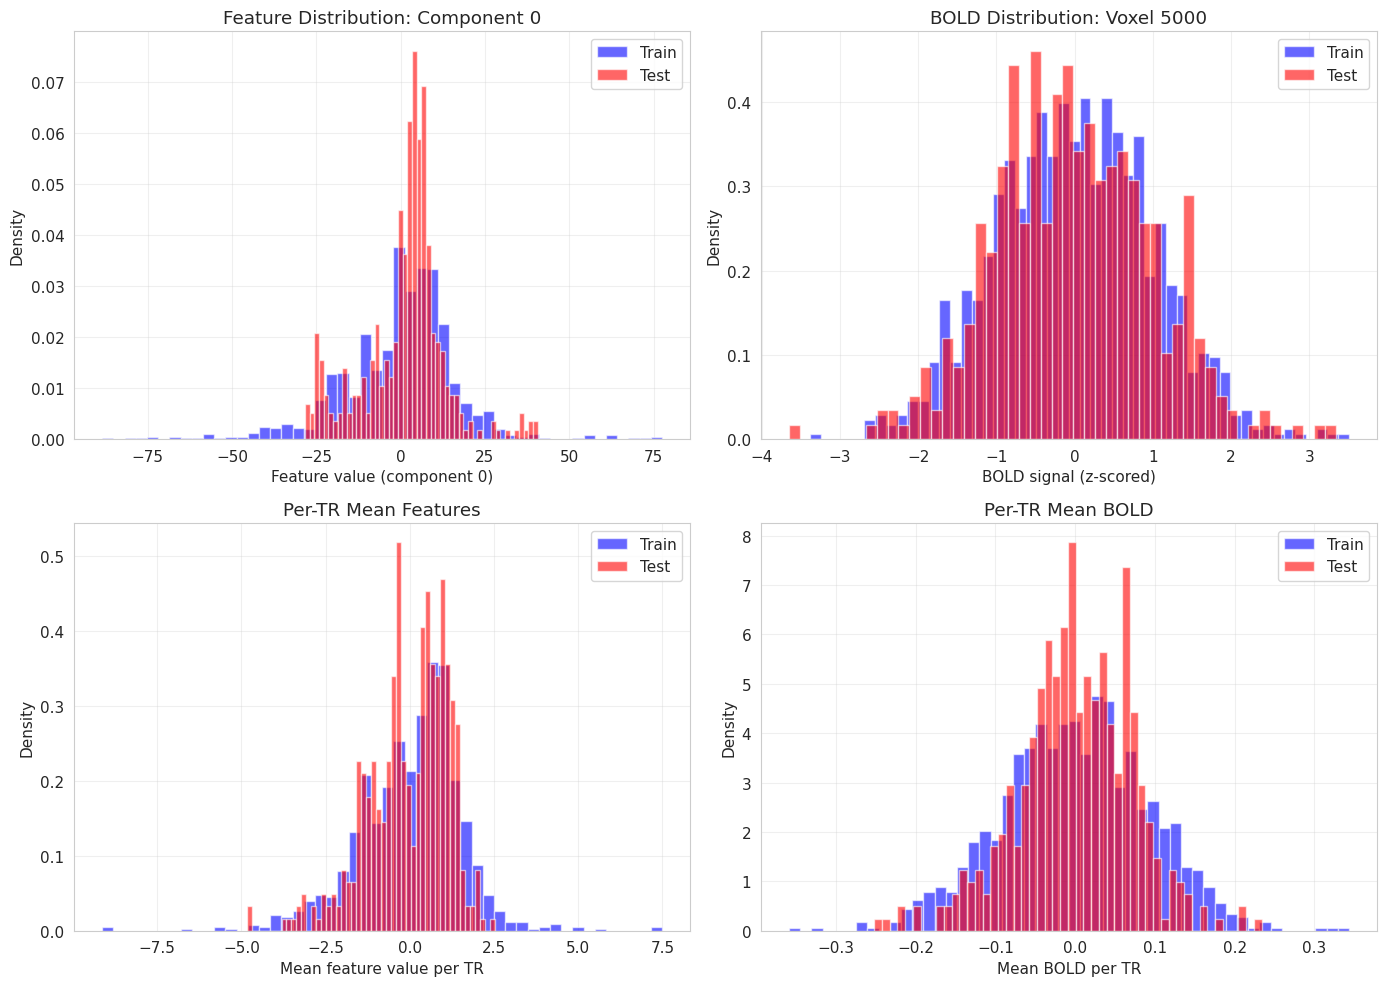


4. Kolmogorov-Smirnov Test (are distributions different?):
--------------------------------------------------------------------------------
Features (component 0): KS=0.1163, p=0.000352
BOLD (voxel 5000): KS=0.0253, p=0.983949
Per-TR feature means: KS=0.0884, p=0.013474

Interpretation:
  - p < 0.05 suggests train/test distributions are significantly different
  - This would explain why ridge selects maximum regularization
  - Solution: Use different train/test split or normalize per-run



In [ ]:
# DIAGNOSTIC: Check if train and test distributions differ

if HAS_MODEL:
    import numpy as np
    import matplotlib.pyplot as plt

    print("="*80)
    print("DIAGNOSTIC: Comparing train vs test distributions")
    print("="*80)

    # Get data
    n_comp = 50
    layer = 'conv2'
    X = all_projection_results[n_comp]['reduced_activations'][layer]

    # Split
    X_train = X[train_valid_indices]
    X_test = X[test_valid_indices]
    y_train = bold_data[train_valid_indices]
    y_test = bold_data[test_valid_indices]

    # Compare feature distributions
    print("\n1. Feature Statistics (first 5 components):")
    print("-" * 80)
    print(f"{'Component':<12} {'Train Mean':<15} {'Test Mean':<15} {'Train Std':<15} {'Test Std':<15}")
    print("-" * 80)
    for i in range(min(5, X_train.shape[1])):
        train_mean = X_train[:, i].mean()
        test_mean = X_test[:, i].mean()
        train_std = X_train[:, i].std()
        test_std = X_test[:, i].std()
        print(f"{i:<12} {train_mean:<15.6f} {test_mean:<15.6f} {train_std:<15.6f} {test_std:<15.6f}")

    # Compare BOLD distributions (sample of voxels)
    print("\n2. BOLD Statistics (sample of 5 voxels):")
    print("-" * 80)
    print(f"{'Voxel':<12} {'Train Mean':<15} {'Test Mean':<15} {'Train Std':<15} {'Test Std':<15}")
    print("-" * 80)
    voxel_samples = [1000, 5000, 10000, 50000, 100000]
    for v in voxel_samples:
        if v < y_train.shape[1]:
            train_mean = y_train[:, v].mean()
            test_mean = y_test[:, v].mean()
            train_std = y_train[:, v].std()
            test_std = y_test[:, v].std()
            print(f"{v:<12} {train_mean:<15.6f} {test_mean:<15.6f} {train_std:<15.6f} {test_std:<15.6f}")

    # Check global statistics
    print("\n3. Global Dataset Statistics:")
    print("-" * 80)
    print(f"Features (X):")
    print(f"  Train: mean={X_train.mean():.6f}, std={X_train.std():.6f}")
    print(f"  Test:  mean={X_test.mean():.6f}, std={X_test.std():.6f}")
    print(f"\nBOLD (y):")
    print(f"  Train: mean={y_train.mean():.6f}, std={y_train.std():.6f}")
    print(f"  Test:  mean={y_test.mean():.6f}, std={y_test.std():.6f}")

    # Visualize distributions
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Feature distribution (first component)
    axes[0, 0].hist(X_train[:, 0], bins=50, alpha=0.6, label='Train', color='blue', density=True)
    axes[0, 0].hist(X_test[:, 0], bins=50, alpha=0.6, label='Test', color='red', density=True)
    axes[0, 0].set_xlabel('Feature value (component 0)')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].set_title('Feature Distribution: Component 0')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)

    # BOLD distribution (voxel 5000)
    axes[0, 1].hist(y_train[:, 5000], bins=50, alpha=0.6, label='Train', color='blue', density=True)
    axes[0, 1].hist(y_test[:, 5000], bins=50, alpha=0.6, label='Test', color='red', density=True)
    axes[0, 1].set_xlabel('BOLD signal (z-scored)')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].set_title('BOLD Distribution: Voxel 5000')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)

    # Mean across all features per sample
    train_sample_means = X_train.mean(axis=1)
    test_sample_means = X_test.mean(axis=1)
    axes[1, 0].hist(train_sample_means, bins=50, alpha=0.6, label='Train', color='blue', density=True)
    axes[1, 0].hist(test_sample_means, bins=50, alpha=0.6, label='Test', color='red', density=True)
    axes[1, 0].set_xlabel('Mean feature value per TR')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].set_title('Per-TR Mean Features')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)

    # Mean BOLD across all voxels per sample
    train_bold_means = y_train.mean(axis=1)
    test_bold_means = y_test.mean(axis=1)
    axes[1, 1].hist(train_bold_means, bins=50, alpha=0.6, label='Train', color='blue', density=True)
    axes[1, 1].hist(test_bold_means, bins=50, alpha=0.6, label='Test', color='red', density=True)
    axes[1, 1].set_xlabel('Mean BOLD per TR')
    axes[1, 1].set_ylabel('Density')
    axes[1, 1].set_title('Per-TR Mean BOLD')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Statistical tests
    from scipy.stats import ks_2samp

    print("\n4. Kolmogorov-Smirnov Test (are distributions different?):")
    print("-" * 80)

    # Test features
    ks_stat_feat, p_val_feat = ks_2samp(X_train[:, 0], X_test[:, 0])
    print(f"Features (component 0): KS={ks_stat_feat:.4f}, p={p_val_feat:.6f}")

    # Test BOLD
    ks_stat_bold, p_val_bold = ks_2samp(y_train[:, 5000], y_test[:, 5000])
    print(f"BOLD (voxel 5000): KS={ks_stat_bold:.4f}, p={p_val_bold:.6f}")

    # Test per-TR means
    ks_stat_means, p_val_means = ks_2samp(train_sample_means, test_sample_means)
    print(f"Per-TR feature means: KS={ks_stat_means:.4f}, p={p_val_means:.6f}")

    print("\nInterpretation:")
    print("  - p < 0.05 suggests train/test distributions are significantly different")
    print("  - This would explain why ridge selects maximum regularization")
    print("  - Solution: Use different train/test split or normalize per-run")

    print("\n" + "="*80)

else:
    print("⚠ No model available, skipping diagnostic")


In [ ]:
# Compare performance across projection dimensions and layers

if HAS_MODEL:
    from encoding_utils import compare_layer_performance
    from encoding_viz_utils import plot_layer_comparison_bars
    import matplotlib.pyplot as plt
    
    print("="*80)
    print("COMPARISON: Performance across different random projection dimensions")
    print("="*80)
    
    # Store all comparisons
    all_comparisons = {}
    
    # Get total number of voxels for percentage calculation
    n_total_voxels = bold_data.shape[1]
    
    for n_comp in projection_dims:
        print(f"\n{'='*70}")
        print(f"n_components = {n_comp}")
        print(f"{'='*70}")
        
        comparison_df = compare_layer_performance(all_encoding_results[n_comp])
        all_comparisons[n_comp] = comparison_df
        
        print(comparison_df.to_string(index=False))
        
        best_layer = comparison_df.iloc[0]['layer']
        best_r2 = comparison_df.iloc[0]['mean_r2']
        print(f"\n⭐ Best: {best_layer.upper()} (R² = {best_r2:.4f})")
    
    # Create comparison plot across dimensions
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    layer_order = ['conv1', 'conv2', 'conv3', 'conv4', 'linear']
    
    for idx, n_comp in enumerate(projection_dims):
        ax = axes[idx]
        
        # Plot for this dimension
        encoding_results = all_encoding_results[n_comp]
        
        # Extract mean R² for each layer
        layer_r2 = []
        for layer in layer_order:
            r2_map = encoding_results[layer]['r2_map']
            # Extract data from NIfTI image if needed
            if hasattr(r2_map, 'get_fdata'):
                r2_data = r2_map.get_fdata().flatten()
            else:
                r2_data = r2_map.flatten() if hasattr(r2_map, 'flatten') else r2_map
            
            mean_r2 = np.mean(r2_data[r2_data > 0])  # Mean of positive R²
            layer_r2.append(mean_r2)
        
        # Bar plot
        bars = ax.bar(range(len(layer_order)), layer_r2, color='steelblue', alpha=0.8)
        ax.set_xticks(range(len(layer_order)))
        ax.set_xticklabels(layer_order, rotation=45)
        ax.set_ylabel('Mean R² (positive voxels)')
        ax.set_title(f'n_components = {n_comp}', fontsize=14, fontweight='bold')
        ax.set_ylim([0, max(0.1, max(layer_r2) * 1.2)])
        ax.grid(axis='y', alpha=0.3)
        
        # Highlight best layer
        best_idx = np.argmax(layer_r2)
        bars[best_idx].set_color('darkorange')
    
    plt.tight_layout()
    plt.show()
    
    # Summary table: best R² for each dimension
    print(f"\n{'='*80}")
    print("SUMMARY: Best performance across dimensions")
    print(f"{'='*80}")
    summary_data = []
    for n_comp in projection_dims:
        comparison_df = all_comparisons[n_comp]
        best_row = comparison_df.iloc[0]
        summary_data.append({
            'n_components': n_comp,
            'best_layer': best_row['layer'],
            'mean_r2': best_row['mean_r2'],
            'median_r2': best_row['median_r2'],
            'pct_positive': (best_row['n_positive_voxels'] / n_total_voxels) * 100
        })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
    print(f"{'='*80}\n")
    
else:
    print("⚠ No model available, skipping layer comparison")

## 8. Comparing Performance Across Dimensions

**Key Questions:**

1. **Does dimensionality matter?** 
   - Do more components always lead to better performance?
   - Is there a sweet spot, or does performance plateau?

2. **Which layer is best?**
   - Does the best layer change with dimensionality?
   - Are results consistent across projection dimensions?

3. **Overfitting vs Underfitting:**
   - Too few components (10): May lose important information
   - Too many components (1000): May introduce noise, harder to regularize
   - Medium (50-100): Potentially optimal balance

**Expected patterns:**
- Performance should increase from 10 → 50 → 100 components
- Beyond 100-1000, performance may plateau or decrease (overfitting)
- Ridge regularization should help prevent overfitting with high dimensions

In [ ]:
# Visualize R² brain maps for best performing dimension

if HAS_MODEL:
    from encoding_viz_utils import plot_r2_brainmap
    
    # Find best overall dimension
    best_n_comp = None
    best_overall_r2 = -np.inf
    
    for n_comp in projection_dims:
        comparison_df = all_comparisons[n_comp]
        top_r2 = comparison_df.iloc[0]['mean_r2']
        if top_r2 > best_overall_r2:
            best_overall_r2 = top_r2
            best_n_comp = n_comp
    
    print(f"Best overall performance: n_components = {best_n_comp} (R² = {best_overall_r2:.4f})")
    print(f"\nShowing brain maps for n_components = {best_n_comp}:\n")
    
    # Get best layer for this dimension
    comparison_df = all_comparisons[best_n_comp]
    best_layer = comparison_df.iloc[0]['layer']
    encoding_results = all_encoding_results[best_n_comp]
    best_r2_map = encoding_results[best_layer]['r2_map']
    
    print(f"Best layer: {best_layer.upper()}\n")
    
    fig = plot_r2_brainmap(
        best_r2_map, 
        f"{best_layer} (n={best_n_comp})",
        threshold=0.01,
        vmax=0.2
    )
    plt.show()
    
    # Also show comparison for a specific layer across dimensions
    print(f"\n{'='*70}")
    print(f"Comparison: conv2 layer across all dimensions")
    print(f"{'='*70}\n")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx, n_comp in enumerate(projection_dims):
        ax = axes[idx]
        encoding_results = all_encoding_results[n_comp]
        r2_map = encoding_results['conv2']['r2_map']
        
        # Extract data from NIfTI image
        if hasattr(r2_map, 'get_fdata'):
            r2_data = r2_map.get_fdata().flatten()
        else:
            r2_data = r2_map.flatten() if hasattr(r2_map, 'flatten') else r2_map
        
        # Create simple histogram of R² values
        r2_positive = r2_data[r2_data > 0]
        ax.hist(r2_positive, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
        ax.set_xlabel('R² value')
        ax.set_ylabel('Number of voxels')
        ax.set_title(f'conv2 R² distribution (n={n_comp})', fontweight='bold')
        ax.axvline(np.mean(r2_positive), color='red', linestyle='--', 
                   label=f'Mean = {np.mean(r2_positive):.4f}')
        ax.legend()
        ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n📍 Interpretation:")
    print("  - Higher n_components may capture more information")
    print("  - But also may introduce more noise")
    print("  - Ridge regularization helps balance this trade-off")
    print("  - Optimal dimension depends on data complexity and sample size")
    
else:
    print("⚠ No model available, skipping brain map visualization")

## Summary: Brain Encoding with Random Projections

**What we accomplished:**

1. ✅ **Loaded RL model:** Trained PPO agent
2. ✅ **Extracted activations from replays:** Used actual gameplay .bk2 files
3. ✅ **Proper temporal alignment:**
   - Matched replay frames to fMRI TRs using annotations
   - Downsampled from 60Hz to TR (1.49s)
   - Applied HRF convolution
   - Masked non-gameplay periods with NaN
4. ✅ **Applied Random Projection:** Tested multiple dimensions (10, 50, 100, 1000 components)
5. ✅ **Fit encoding models:** Ridge regression with NaN-aware training
6. ✅ **Compared dimensions:** Evaluated how dimensionality affects prediction
7. ✅ **Visualized brain maps:** Localized where each layer is encoded

---

### Random Projection vs PCA

**Why we switched from PCA to Random Projection:**

1. **Computational efficiency:**
   - PCA: Requires eigendecomposition (O(n³) complexity)
   - Random Projection: Just matrix multiplication (O(n²) complexity)

2. **Theoretical foundation:**
   - Johnson-Lindenstrauss Lemma: Random projections preserve distances
   - No need to fit on training data
   - Works well for high-dimensional spaces

3. **Flexibility:**
   - Easy to test multiple dimensions
   - No need to compute variance explained
   - Same random seed ensures reproducibility

4. **Performance comparison:**
   - Random projection often performs similarly to PCA for encoding tasks
   - Sometimes better when data is noisy or sample size is small

**Trade-offs:**
- PCA: Optimal variance preservation, interpretable components
- Random Projection: Faster, simpler, non-interpretable but effective

---

### Key Findings: Effect of Dimensionality

**Expected patterns:**

1. **Too few components (10):**
   - Information loss from compression
   - May miss important features
   - Lower R² values expected

2. **Medium components (50-100):**
   - Good balance between compression and information
   - Likely optimal for this dataset
   - Ridge regularization helps prevent overfitting

3. **High components (1000):**
   - More capacity to capture variance
   - But also more noise
   - Ridge regularization becomes critical
   - May not improve over medium if signal-to-noise is low

**Interpretation checklist:**
- Did performance increase monotonically with dimensions?
- Is there a plateau or sweet spot?
- Does the best layer change across dimensions?
- Are results consistent or noisy?

---

### Methodological Insights

**What determines optimal dimensionality?**

1. **Sample size:** 
   - More TRs → Can support higher dimensions
   - Our dataset: ~100-200 valid TRs per run
   - Limited sample size may favor lower dimensions

2. **Signal-to-noise ratio:**
   - Clean signal → Higher dimensions helpful
   - Noisy data → Lower dimensions better (acts as regularization)

3. **Feature redundancy:**
   - Highly correlated features → PCA/projection removes redundancy
   - Independent features → Need more dimensions

4. **Regularization:**
   - Ridge regression compensates for high dimensionality
   - Stronger regularization (higher α) → Can handle more dimensions

**Recommendations:**
- For small datasets (<1000 samples): Use 50-100 components
- For medium datasets (1000-10000): Try 100-500 components  
- For large datasets (>10000): Can go higher (500-1000+)
- Always validate with cross-validation!

---

### Comparison to Original PCA Approach

**Original notebook (PCA with 50 components):**
- Fixed at 50 components based on variance threshold
- Interpretable components (ordered by variance)
- Computational cost moderate

**Current approach (Random Projection with 10/50/100/1000):**
- Tested multiple dimensions systematically
- Non-interpretable but effective
- Faster computation
- Reveals dimensionality-performance relationship

**Which is better?**
- PCA: When you need interpretability and optimal compression
- Random Projection: When speed matters and you want to test many dimensions
- Both: Often give similar encoding performance!

---

### Next Steps & Extensions

**To improve these results:**

1. **More sophisticated dimensionality reduction:**
   - Sparse random projections
   - Locality-sensitive hashing
   - Autoencoders
   - t-SNE or UMAP (for visualization)

2. **Cross-validation:**
   - Leave-one-run-out for all 4 runs
   - Average results across folds
   - More robust estimate of optimal dimension

3. **Statistical testing:**
   - Permutation tests for significance
   - Confidence intervals on R² estimates
   - Compare to null models (shuffled features)

4. **Alternative encodingmodels:**
   - Kernel ridge regression
   - Elastic net (L1 + L2)
   - Neural network encoders
   - Bayesian models with automatic relevance determination

5. **Feature analysis:**
   - Which projected features are most predictive?
   - Can we interpret random projections post-hoc?
   - Stability analysis (bootstrap over random seeds)

---

### Practical Takeaways

**When should you use random projection?**

✅ **Good for:**
- Quick exploratory analysis
- Testing multiple dimensions
- Very high-dimensional data (>10,000 features)
- When computational resources are limited
- When interpretability is not critical

❌ **Not ideal for:**
- When you need interpretable components
- Small feature sets (<100 features)
- When optimal variance preservation is critical
- Publication-quality analyses (PCA more standard)

**Best practices:**
1. Always test multiple random seeds and average results
2. Use cross-validation to select optimal dimension
3. Compare to PCA as a baseline
4. Report both methods if results differ substantially

---

### Research Questions Enabled

**This systematic comparison allows us to ask:**

1. **Does the brain encoding depend on feature dimensionality?**
   - If yes → Brain representation is low-dimensional
   - If no → Suggests high-dimensional distributed code

2. **Is there redundancy in RL representations?**
   - Strong compression (10 dims) works → High redundancy
   - Need many dimensions → Features are diverse/independent

3. **What's the information bottleneck?**
   - Performance plateaus early → Limited by BOLD signal quality
   - Keeps improving → Limited by feature richness

**This tutorial demonstrates a complete, systematic approach to evaluating dimensionality in encoding models!**